<img src="https://wandb.me/logo-im-png" width="400" alt="Weights & Biases" />

<!-- @wandbcode{xgb-sweeps} -->

Use Weights & Biases for machine learning experiment tracking, dataset versioning, and project collaboration.


<img src="http://wandb.me/mini-diagram" width="650" alt="Weights & Biases" />

<a href="https://colab.research.google.com/github/wandb/examples/blob/master/colabs/boosting/Using_W%26B_Sweeps_with_XGBoost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



# Using W&B Sweeps with XGBoost

Squeezing the best performance out of tree-based models requires
[selecting the right hyperparameters](https://blog.cambridgespark.com/hyperparameter-tuning-in-xgboost-4ff9100a3b2f).
How many `early_stopping_rounds`? What should the `max_depth` of a tree be?

Searching through high dimensional hyperparameter spaces to find the most performant model can get unwieldy very fast.
Hyperparameter sweeps provide an organized and efficient way to conduct a battle royale of models and crown a winner.
They enable this by automatically searching through combinations of hyperparameter values to find the most optimal values.

In this tutorial we'll see how you can run sophisticated hyperparameter sweeps on XGBoost models in 3 easy steps using Weights and Biases.

For a teaser, check out the plots below:

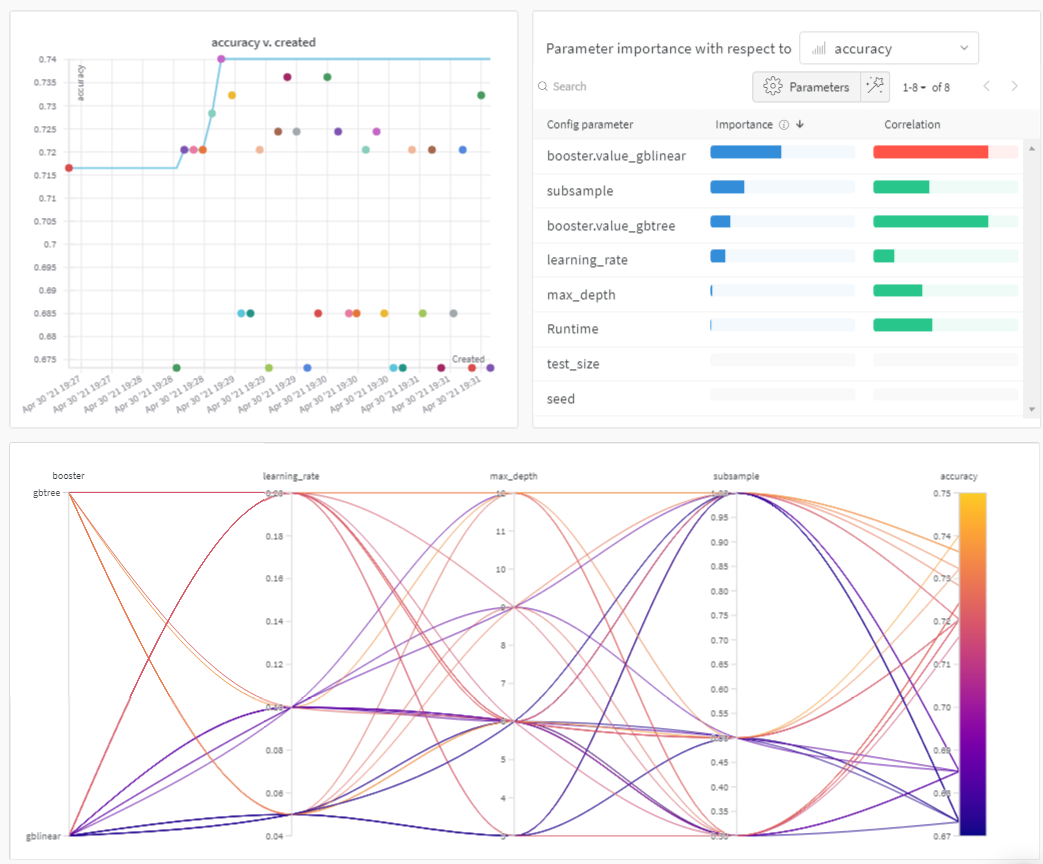



## Sweeps: An Overview

Running a hyperparameter sweep with Weights & Biases is very easy. There are just 3 simple steps:

1. **Define the sweep:** we do this by creating a dictionary-like object that specifies the sweep: which parameters to search through, which search strategy to use, which metric to optimize.

2. **Initialize the sweep:** with one line of code we initialize the sweep and pass in the dictionary of sweep configurations:
`sweep_id = wandb.sweep(sweep_config)`

3. **Run the sweep agent:** also accomplished with one line of code, we call w`andb.agent()` and pass the `sweep_id` along with a function that defines your model architecture and trains it:
`wandb.agent(sweep_id, function=train)`

And voila! That's all there is to running a hyperparameter sweep!

In the notebook below, we'll walk through these 3 steps in more detail.

We highly encourage you to fork this notebook, tweak the parameters, or try the model with your own dataset!

### Resources
- [Sweeps docs →](https://docs.wandb.com/library/sweeps)
- [Launching from the command line →](https://www.wandb.com/articles/hyperparameter-tuning-as-easy-as-1-2-3)


In [ ]:
!pip install wandb -qqq
import wandb
wandb.login()

## 1. Define the Sweep

Weights & Biases sweeps give you powerful levers to configure your sweeps exactly how you want them, with just a few lines of code. The sweeps config can be defined as
[a dictionary or a YAML file](https://docs.wandb.ai/guides/sweeps/configuration).

Let's walk through some of them together:
*   **Metric** – This is the metric the sweeps are attempting to optimize. Metrics can take a `name` (this metric should be logged by your training script) and a `goal` (`maximize` or `minimize`). 
*   **Search Strategy** – Specified using the `"method"` key. We support several different search strategies with sweeps. 
  *   **Grid Search** – Iterates over every combination of hyperparameter values.
  *   **Random Search** – Iterates over randomly chosen combinations of hyperparameter values.
  *   **Bayesian Search** – Creates a probabilistic model that maps hyperparameters to probability of a metric score, and chooses parameters with high probability of improving the metric. The objective of Bayesian optimization is to spend more time in picking the hyperparameter values, but in doing so trying out fewer hyperparameter values.
*   **Parameters** – A dictionary containing the hyperparameter names, and discrete values, a range, or distributions from which to pull their values on each iteration.

You can find a list of all configuration options [here](https://docs.wandb.com/library/sweeps/configuration).

In [ ]:
sweep_config = {
    "method": "random", # try grid or random
    "metric": {
      "name": "accuracy",
      "goal": "maximize"   
    },
    "parameters": {
        "booster": {
            "values": ["gbtree","gblinear"]
        },
        "max_depth": {
            "values": [3, 6, 9, 12]
        },
        "learning_rate": {
            "values": [0.1, 0.05, 0.2]
        },
        "subsample": {
            "values": [1, 0.5, 0.3]
        }
    }
}

## 2. Initialize the Sweep

Calling `wandb.sweep` starts a Sweep Controller --
a centralized process that provides settings of the `parameters` to any who query it
and expects them to return performance on `metrics` via `wandb` logging.

In [ ]:
sweep_id = wandb.sweep(sweep_config, project="XGBoost-sweeps")

### Define your training process
Before we can run the sweep,
we need to define a function that creates and trains the model --
the function that takes in hyperparameter values and spits out metrics.

We'll also need `wandb` to be integrated into our script.
There's three main components:
*   `wandb.init()` – Initialize a new W&B run. Each run is single execution of the training script.
*   `wandb.config` – Save all your hyperparameters in a config object. This lets you use [our app](https://wandb.ai) to sort and compare your runs by hyperparameter values.
*   `wandb.log()` – Logs metrics and custom objects – these can be images, videos, audio files, HTML, plots, point clouds etc.

We also need to download the data:

In [ ]:
!wget https://raw.githubusercontent.com/jbrownlee/Datasets/master/pima-indians-diabetes.data.csv

In [ ]:
# XGBoost model for Pima Indians dataset
from numpy import loadtxt
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# load data
def train():
  config_defaults = {
    "booster": "gbtree",
    "max_depth": 3,
    "learning_rate": 0.1,
    "subsample": 1,
    "seed": 117,
    "test_size": 0.33,
  }

  wandb.init(config=config_defaults)  # defaults are over-ridden during the sweep
  config = wandb.config

  # load data and split into predictors and targets
  dataset = loadtxt("pima-indians-diabetes.data.csv", delimiter=",")
  X, Y = dataset[:, :8], dataset[:, 8]

  # split data into train and test sets
  X_train, X_test, y_train, y_test = train_test_split(X, Y,
                                                      test_size=config.test_size,
                                                      random_state=config.seed)

  # fit model on train
  model = XGBClassifier(booster=config.booster, max_depth=config.max_depth,
                        learning_rate=config.learning_rate, subsample=config.subsample)
  model.fit(X_train, y_train)

  # make predictions on test
  y_pred = model.predict(X_test)
  predictions = [round(value) for value in y_pred]

  # evaluate predictions
  accuracy = accuracy_score(y_test, predictions)
  print(f"Accuracy: {int(accuracy * 100.)}%")
  wandb.log({"accuracy": accuracy})

## 3. Run the Sweep with an agent

Now, we call `wandb.agent` to start up our sweep.

You can call `wandb.agent` on any machine where you're logged into W&B that has
- the `sweep_id`,
- the dataset and `train` function

and that machine will join the sweep!

> _Note_: a `random` sweep will by defauly run forever,
trying new parameter combinations until the cows come home --
or until you [turn the sweep off from the app UI](https://docs.wandb.ai/ref/app/features/sweeps).
You can prevent this by providing the total `count` of runs you'd like the `agent` to complete.

In [ ]:
wandb.agent(sweep_id, train, count=25)

## Visualize your results


Now that your sweep is finished, it's time to look at the results.

Weights & Biases will generate a number of useful plots for you automatically.

### Parallel coordinates plot

This plot maps hyperparameter values to model metrics. It’s useful for honing in on combinations of hyperparameters that led to the best model performance.

This plot seems to indicate that using a tree as our learner slightly,
but not mind-blowingly,
outperforms using a simple linear model as our learner.

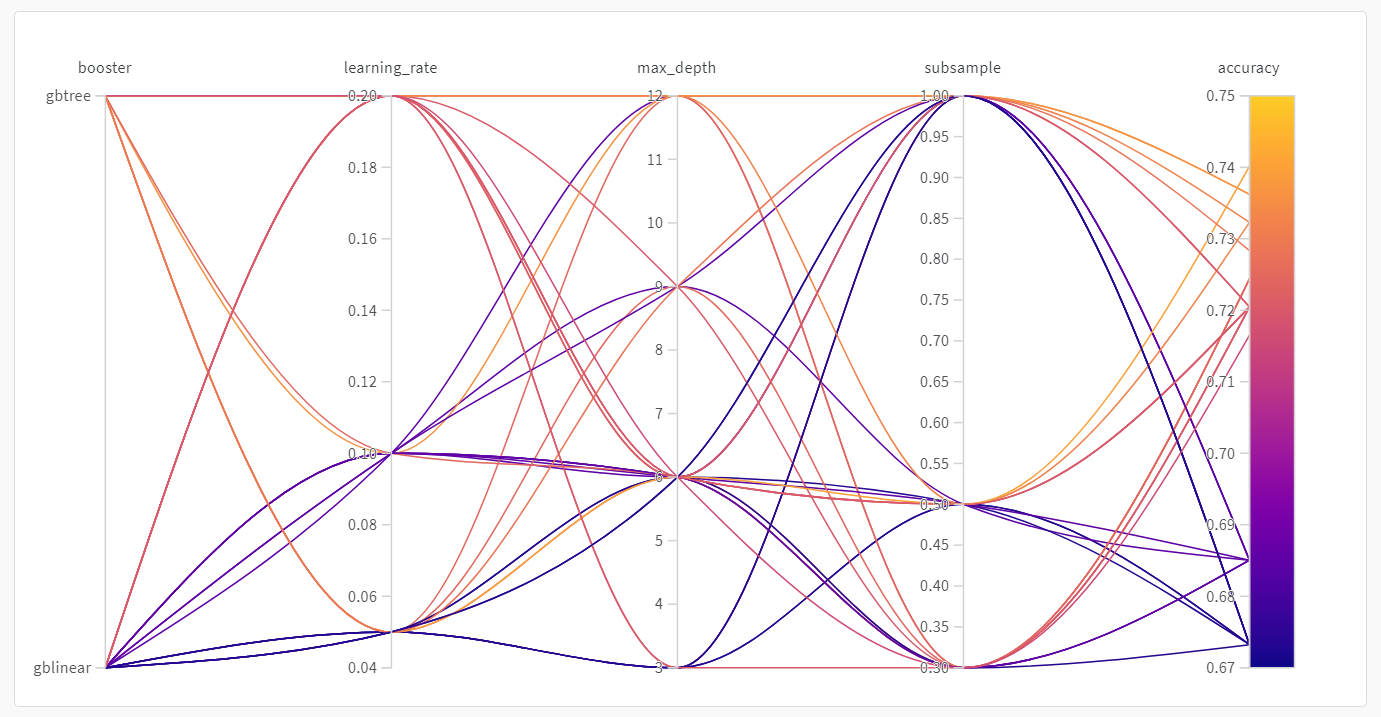

### Hyperparameter importance plot

The hyperparameter importance plot shows which hyperparameter values had the biggest impact
on your metrics.

We report both the correlation (treating it as a linear predictor)
and the feature importance (after training a random forest on your results)
so you can see which parameters had the biggest effect
and whether that effect was positive or negative.

Reading this chart, we see quantitative confirmation 
of the trend we noticed in the parallel coordinates chart above:
the largest impact on validation accuracy came from the choice of
learner, and the `gblinear` learners were generally worse than `gbtree` learners.

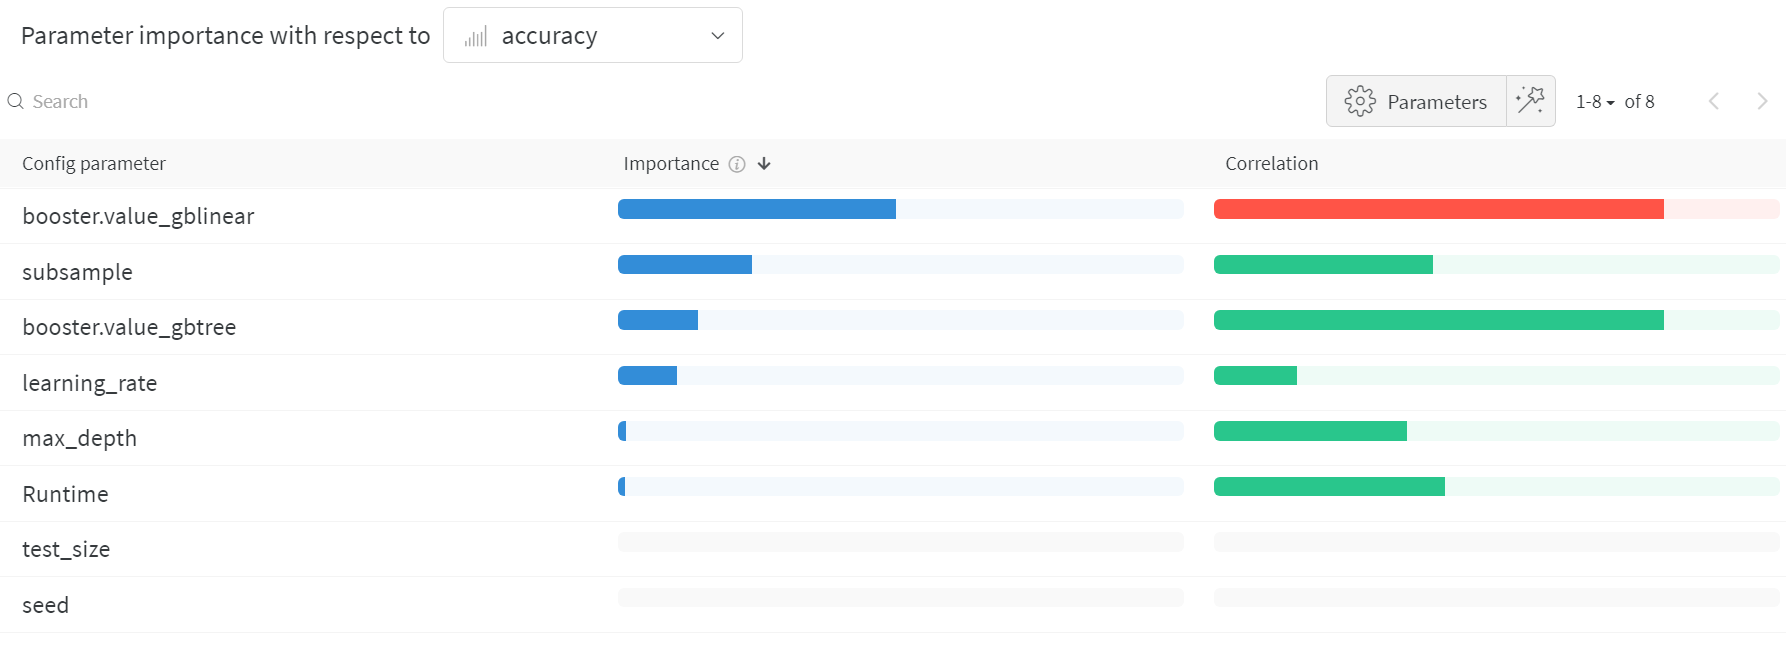


These visualizations can help you save both time and resources running expensive hyperparameter optimizations by honing in on the parameters (and value ranges) that are the most important, and thereby worthy of further exploration.
